---
 acquisition data norm: 2.212010e+02
---
 pre-processing acquisition data...
---
 processed acquisition data norm: 2.090210e+02
---
 reconstructed images norm: 2.090212e+02
--- image 0
version 1
flags 0
data_type 7
channels 1
slice 0
repetition 0
image_type 1
image_index 1
image_series_index 0
matrix size: (1, 256, 256)
patient_table_position: (0.0, 0.0, 0.0)
--- image 1
version 1
flags 0
data_type 7
channels 1
slice 0
repetition 1
image_type 1
image_index 2
image_series_index 0
matrix size: (1, 256, 256)
patient_table_position: (0.0, 0.0, 0.0)
image indices:
[1 2]
patient table positions:
[(0.0, 0.0, 0.0) (0.0, 0.0, 0.0)]
---
 sorting acquisition data...
---
 computing coil sensitivity maps...
---
 reconstructed images forward projection norm 2.090210e+02
Close Figure 1 window to continue...


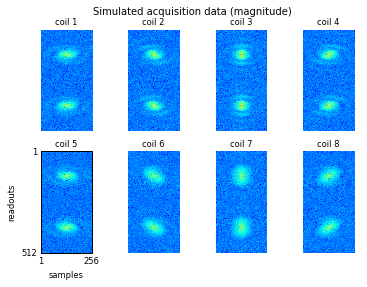

Close Figure 1 window to continue...


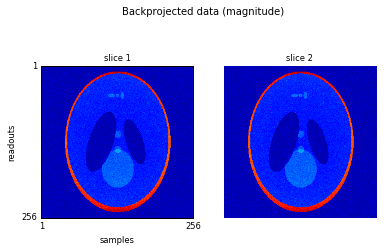

0

In [3]:
#'''
#Upper-level demo that illustrates the computation of coil sensitivity maps
#and applying projection from the image space into acquisition space and back
#defined by the aquisition model.
#
#Usage:
#  acquisition_model.py [--help | options]
#
#Options:
#  -f <file>, --file=<file>    raw data file
#                              [default: simulated_MR_2D_cartesian.h5]
# -p <path>, --path=<path>    path to data files, defaults to data/examples/MR
#                              subfolder of SIRF root folder
#  -o <file>, --output=<file>  output file for simulated data
#  -e <engn>, --engine=<engn>  reconstruction engine [default: Gadgetron]
#'''
#
## CCP PETMR Synergistic Image Reconstruction Framework (SIRF)
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC
## Copyright 2015 - 2017 University College London.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'
from docopt import docopt
#args = docopt(__doc__, version=__version__)

from pUtilities import show_3D_array

# import engine module
#exec('from p' + args['--engine'] + ' import *')
from pGadgetron import *

# process command-line options
data_file = 'simulated_MR_2D_cartesian.h5'
data_path = petmr_data_path('mr')
output_file = 'acqmodel_gen.h5'


# locate the k-space raw data file
input_file = existing_filepath(data_path, data_file)

# acquisition data will be read from an HDF file input_file
acq_data = AcquisitionData(input_file)
print('---\n acquisition data norm: %e' % acq_data.norm())

# pre-process acquisition data
print('---\n pre-processing acquisition data...')
processed_data = preprocess_acquisition_data(acq_data)
print('---\n processed acquisition data norm: %e' % processed_data.norm())

# perform reconstruction to obtain a meaningful ImageData object
# (cannot be obtained in any other way at present)
recon = FullySampledReconstructor()
recon.set_input(processed_data)
recon.process()
complex_images = recon.get_output()
print('---\n reconstructed images norm: %e' % complex_images.norm())

for i in range(complex_images.number()):
    complex_image = complex_images.image(i)
    print('--- image %d' % i)
    for p in [ \
        'version', 'flags', 'data_type', 'channels', \
        'slice', 'repetition', \
        'image_type', 'image_index', 'image_series_index' \
        ]:
        form = p + ' %d'
        print(form % complex_image.info(p))
    print('matrix size:'),
    print(complex_image.matrix_size())
    print('patient_table_position:'),
    print(complex_image.patient_table_position())

ind = complex_images.get_info('image_index')
print('image indices:')
print(ind)
ptp = complex_images.get_info('patient_table_position')
print('patient table positions:')
print(ptp)
    
# sort processed acquisition data;
# sorting currently performed with respect to (in this order):
#    - repetition
#    - slice
#    - kspace encode step 1
print('---\n sorting acquisition data...')
processed_data.sort()

# compute coil sensitivity maps
print('---\n computing coil sensitivity maps...')
csms = CoilSensitivityData()
csms.calculate(processed_data)
# alternatively, coil sensitivity maps can be computed from
# CoilImageData - see coil_sensitivity_maps.py

# create acquisition model based on the acquisition parameters
# stored in processed_data and image parameters stored in complex_images
acq_model = AcquisitionModel(processed_data, complex_images)
acq_model.set_coil_sensitivity_maps(csms)

# use the acquisition model (forward projection) to produce simulated
# acquisition data
simulated_acq_data = acq_model.forward(complex_images)
print('---\n reconstructed images forward projection norm %e'\
        % simulated_acq_data.norm())
if output_file is not None:
    simulated_acq_data.write(output_file)

# get simulated acquisition data as a Python ndarray
simulated_acq_array = simulated_acq_data.as_array();
# display simulated acquisition data
#    simulated_acq_array = numpy.transpose(simulated_acq_array,(1,2,0))
simulated_acq_array = numpy.transpose(simulated_acq_array,(1,0,2))
%matplotlib inline
title = 'Simulated acquisition data (magnitude)'
show_3D_array(simulated_acq_array, power = 0.2, suptitle = title, \
                  xlabel = 'samples', ylabel = 'readouts', label = 'coil')

# backproject simulated acquisition data
backprojected_data = acq_model.backward(simulated_acq_data)
# show backprojected data
backprojected_array = backprojected_data.as_array()
title = 'Backprojected data (magnitude)'
show_3D_array(abs(backprojected_array), suptitle = title, \
                  xlabel = 'samples', ylabel = 'readouts', label = 'slice')

